# Penalized Linear Regressions: A Simulation Experiment

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV, ElasticNetCV, LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.base import BaseEstimator
random.seed(5)

## Data Generating Process

  The function creates synthetic data for regression with varying coefficient structures. It’s useful for testing models under different feature importance scenarios.

1. Regimes:

  - "sparse": Only the first few features have substantial influence; later ones decay rapidly.
  - "dense": All features moderately affect the response (common in complex systems).
  - "sparsedense": Mimics situations where a few features dominate but many others have small effects.

2. True Function true_fn:
  -Computes noise-free predictions. This helps evaluate models' ability to capture the true signal versus just fitting noise.

3. Population Data:
  A large dataset (Xpop, ypop) approximates the entire population, ideal for analyzing generalization and population-level metrics.

4. Noise Addition:
  Gaussian noise simulates real-world measurement error, making the problem more realistic.

$y=X.\beta+\epsilon$

In [ ]:
def gen_data(n, p, *, regime="sparse"):
    """
    Generates synthetic regression data with different sparsity regimes.

    Parameters:
    - n (int): Number of samples for training and testing datasets.
    - p (int): Number of features.
    - regime (str, optional): Type of coefficient sparsity. Options:
        - "sparse": Coefficients decay quadratically (few dominant features).
        - "dense": Coefficients drawn from normal distribution (many moderate features).
        - "sparsedense": Combination of sparse and dense coefficients.

    Returns:
    - X (ndarray): Training feature matrix of shape (n, p).
    - y (ndarray): Training target vector with added noise.
    - gX (ndarray): True target values without noise (training set).
    - Xtest (ndarray): Testing feature matrix of shape (n, p).
    - ytest (ndarray): Testing target vector with noise.
    - gXtest (ndarray): True target values without noise (testing set).
    - Xpop (ndarray): Population-level feature matrix (100,000 samples).
    - ypop (ndarray): Population-level target values with noise.
    - gXpop (ndarray): Population-level true target values without noise.
    - beta (ndarray): True coefficient vector of shape (p,).
    """

    # Set true coefficients based on the chosen regime
    if regime == "sparse":
        # Sparse regime: Coefficients decay quadratically with the feature index
        # This creates a scenario where a few features are strongly predictive.
        beta = ((1 / np.arange(1, p + 1)) ** 2) * 7

    elif regime == "dense":
        # Dense regime: All features have moderate influence, drawn from normal distribution
        beta = np.random.normal(0, 1, p) * 0.35

    elif regime == "sparsedense":
        # Mixed regime: Combination of sparse and dense influences
        # Quadratically decaying part + moderate noise from normal distribution
        beta = (((1 / np.arange(1, p + 1)) ** 2) * 5) + (np.random.normal(0, 1, p) * 0.25)

    def true_fn(x):
        """Calculates the true (noise-free) response using the linear model."""
        return x @ beta  # Matrix-vector multiplication for predicted values

    # Generate training features from a uniform distribution in [-0.5, 0.5]
    X = np.random.uniform(-0.5, 0.5, size=(n, p))
    gX = true_fn(X)  # True target without noise
    y = gX + np.random.normal(0, 1, size=n)  # Add Gaussian noise for observed target

    # Generate test dataset similarly for out-of-sample evaluation
    Xtest = np.random.uniform(-0.5, 0.5, size=(n, p))
    gXtest = true_fn(Xtest)
    ytest = gXtest + np.random.normal(0, 1, size=n)

    # Generate large population-level dataset (used to approximate population metrics)
    Xpop = np.random.uniform(-0.5, 0.5, size=(100000, p))
    gXpop = true_fn(Xpop)
    ypop = gXpop + np.random.normal(0, 1, size=100000)

    return X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, beta


## Data Generating Process: Approximately Sparse

In [ ]:
n = 100
p = 400
X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, betas = gen_data(n, p, regime="sparse")

- Sample size (n=100): Generates training and test sets with 100 samples each.

- Number of features (p=400): Each sample has 400 features. This creates a high-dimensional scenario where the number of features exceeds the sample size, often seen in genomic data, text features, or image pixels.

- Regime ("sparse"):
Only the first few features are influential, with coefficients decreasing quadratically. Most features contribute little or no information.

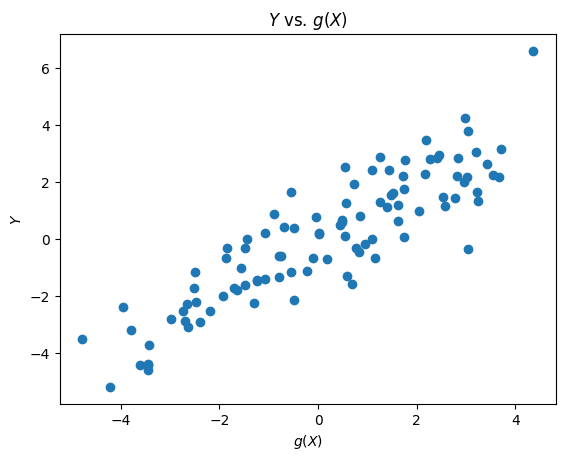

In [ ]:
plt.figure()
plt.title(r"$Y$ vs. $g(X)$")
plt.scatter(gX, y)
plt.xlabel(r"$g(X)$")
plt.ylabel(r"$Y$")
plt.show()

In [ ]:
print(f"theoretical R^2:, {1 - np.var(ypop - gXpop) / np.var(ypop)}")
print(f"theoretical R^2:, {np.var(gXpop) / np.var(ypop)}")

theoretical R^2:, 0.815686611659733
theoretical R^2:, 0.8144977728960222


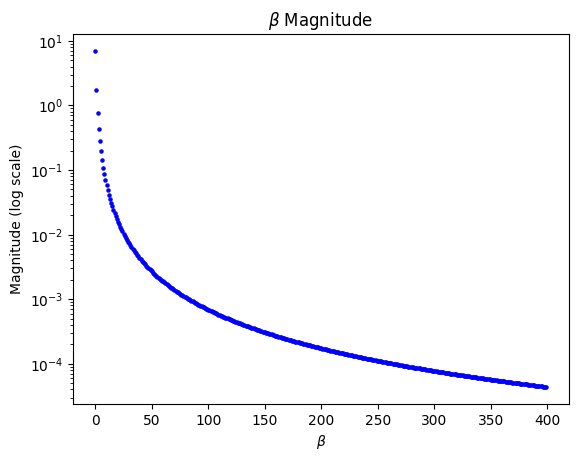

In [ ]:
plt.figure()
plt.scatter(range(len(betas)), abs(betas), s=5, color='b')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnitude (log scale)')
plt.title(r'$\beta$ Magnitude')
plt.yscale('log')
plt.show()

## Lasso, Ridge, ElasticNet

We use sklearn's penalized estimators, which choose the penalty parameter via cross-validation (by default 5-fold cross-validation). These methods search over an adaptively chosen grid of hyperparameters. `ElasticNet` allows for a convex combination of `l1` and `l2` penalty and the ratio with `l1_ratio` corresponding to the proportion of the `l1` penalty.

This code performs three types of regularized regression using cross-validation to select optimal hyperparameters:

In [ ]:
# Regressions
lcv = LassoCV().fit(X, y)
ridge = RidgeCV().fit(X, y)
enet = ElasticNetCV(l1_ratio=0.5).fit(X, y) #l1 is taken as 0.5

- Lasso Regression (LassoCV):
Penalizes the absolute values of coefficients (L1 penalty).
Encourages sparsity (i.e., some coefficients shrink to zero).
Useful for feature selection when dealing with many irrelevant features.
LassoCV uses cross-validation to find the best alpha (regularization strength).

- Ridge Regression (RidgeCV):
Penalizes the square of the coefficients (L2 penalty).
Shrinks coefficients but doesn’t zero them out.
Helps when dealing with multicollinearity or high-dimensional data.
RidgeCV selects the best alpha through cross-validation.


Elastic Net (ElasticNetCV):

- Combines L1 (Lasso) and L2 (Ridge) penalties.
Balances sparsity and coefficient shrinkage.
l1_ratio=0.5: Equal emphasis on Lasso and Ridge components.
ElasticNetCV finds the best combination of alpha and l1_ratio.

We calculate the R-squared on the small test set that we have

In [ ]:
r2_lcv = r2_score(ytest, lcv.predict(Xtest))
r2_ridge = r2_score(ytest, ridge.predict(Xtest))
r2_enet = r2_score(ytest, enet.predict(Xtest))
r2_lcv, r2_ridge, r2_enet

(0.7742313163669147, 0.12410572462749792, 0.560779394732962)

What is R²?
- R² (Coefficient of Determination) measures how well the model explains the variability of the target variable.
- Values range from:
  - 1.0: Perfect fit
  - 0.0: Model explains no variance beyond the mean
  - < 0.0: Worse than just predicting the mean

Interpreting Results:
- High R² (closer to 1): Model captures the true signal effectively.
- Lower R² for Lasso (in high-dimensional data): Lasso may overshrink coefficients.
- Ridge might outperform Lasso when many small but relevant features exist.
- Elastic Net balances both: Good if there’s a mix of sparse and dense signals.

We also calculate what the R-squared would be in the population limit (in our case for practical purposes when we have a very very large test sample)

In [ ]:
r2_lcv = r2_score(ypop, lcv.predict(Xpop))
r2_ridge = r2_score(ypop, ridge.predict(Xpop))
r2_enet = r2_score(ypop, enet.predict(Xpop))
r2_lcv, r2_ridge, r2_enet

(0.7574179170188436, 0.1586121217054628, 0.5453199344235287)

We can also try this with fitting OLS after Lasso selects variables, but note, this is the wrong post-lasso OLS with cross-validation!

What is Post-Lasso OLS?
- Lasso for Feature Selection:
Lasso identifies important features by shrinking some coefficients to zero.
- OLS (Ordinary Least Squares) Refit:
After selecting features, a standard linear regression refines coefficient estimates without penalty, often improving prediction and reducing bias from Lasso’s shrinkage.

In [ ]:
from sklearn.linear_model import LassoCV, LinearRegression
import numpy as np

class PostLassoOLS:
    def fit(self, X, y):
        """
        Fits a Lasso model to select features, then refits OLS on the selected features.

        Parameters:
        - X (ndarray): Feature matrix of shape (n_samples, n_features).
        - y (ndarray): Target vector of shape (n_samples,).

        Returns:
        - self: Fitted PostLassoOLS instance.
        """
        # Lasso for feature selection (with cross-validation for alpha)
        lasso = LassoCV().fit(X, y)

        # Identify selected features (non-zero coefficients)
        self.feats_ = np.abs(lasso.coef_) > 1e-6  # Boolean mask for selected features

        #  Fit OLS on the subset of features selected by Lasso
        self.lr_ = LinearRegression().fit(X[:, self.feats_], y)

        return self

    def predict(self, X):
        """
        Predict target values using the OLS model on selected features.

        Parameters:
        - X (ndarray): Feature matrix for prediction.

        Returns:
        - predictions (ndarray): Predicted values.
        """
        return self.lr_.predict(X[:, self.feats_])  # Use only selected features

    @property
    def coef_(self):
        """
        Returns the coefficients from the OLS model.

        Returns:
        - coef_ (ndarray): Coefficient values for selected features.
        """
        return self.lr_.coef_


Why Use Post-Lasso OLS?
- Lasso alone shrinks coefficients, introducing bias.
- Post-Lasso OLS keeps Lasso’s feature selection but removes bias by using OLS on selected features.
- Often leads to improved prediction accuracy and more interpretable models

In [ ]:
plols = PostLassoOLS().fit(X, y)
r2_score(ypop, plols.predict(Xpop))

0.7515279762848878

## Plug-in Hyperparameter Lasso and Post-Lasso OLS

Here we compute the lasso and ols post lasso using plug-in choices for penalty levels.

\We use "plug-in" tuning with a theoretically valid choice of penalty $\lambda = 2 \cdot c \hat{\sigma} \sqrt{n} \Phi^{-1}(1-\alpha/2p)$, where $c>1$ and $1-\alpha$ is a confidence level, and $\Phi^{-1}$ denotes the quantile function. Under homoskedasticity, this choice ensures that the Lasso predictor is well behaved, delivering good predictive performance under approximate sparsity. In practice, this formula will work well even in the absence of homoskedasticity, especially when the random variables $\epsilon$ and $X$ in the regression equation decay quickly at the tails.

In practice, many people choose to use cross-validation, which is perfectly fine for predictive tasks. However, when conducting inference, to make our analysis valid we will require cross-fitting in addition to cross-validation. As we have not yet discussed cross-fitting, we rely on this theoretically-driven penalty in order to allow for accurate inference in the upcoming notebooks.

We pull an analogue of R's rlasso. Rlasso functionality: it is searching the right set of regressors. This function was made for the case of ***p*** regressors and ***n*** observations where ***p >>>> n***. It assumes that the error is i.i.d. The errors may be non-Gaussian or heteroscedastic.\
The post lasso function makes OLS with the selected ***T*** regressors.
To select those parameters, they use $\lambda$ as variable to penalize\
**Funny thing: the function rlasso was named like that because it is the "rigorous" Lasso.**\
We find a Python code that tries to replicate the main function of hdm r-package. It was made by [Max Huppertz](https://maxhuppertz.github.io/code/). His library is this [repository](https://github.com/maxhuppertz/hdmpy). If not using colab, download its repository and copy this folder to your site-packages folder. In my case it is located here ***C:\Python\Python38\Lib\site-packages*** . We need to install this package ***pip install multiprocess***.

In [ ]:
!git clone https://github.com/maxhuppertz/hdmpy.git
!pip install multiprocess

Cloning into 'hdmpy'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 39), reused 52 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 25.30 KiB | 3.16 MiB/s, done.
Resolving deltas: 100% (39/39), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.0 MB/s eta 0:00:00


What is RLasso?
- RLasso (Regularized Lasso) comes from the hdmpy package, which implements high-dimensional methods used in econometrics and statistics.
- It combines Lasso-based variable selection with robust statistical inference.
- The post option controls whether it performs Post-Lasso OLS after selecting features.


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator
import hdmpy  # High-dimensional methods in Python

class RLasso(BaseEstimator):
    def __init__(self, *, post=True):
        """
        Wrapper for hdmpy.rlasso with sklearn-compatible API.

        Parameters:
        - post (bool): If True, performs Post-Lasso OLS after feature selection.
        """
        self.post = post

    def fit(self, X, y):
        """
        Fits the R-Lasso model.

        Parameters:
        - X (ndarray): Feature matrix (n_samples, n_features).
        - y (ndarray): Target vector (n_samples,).

        Returns:
        - self: Fitted RLasso instance.
        """
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)  # Fit R-Lasso with/without post-Lasso OLS
        return self

    def predict(self, X):
        """
        Predict target values using the fitted R-Lasso model.

        Parameters:
        - X (ndarray): Feature matrix for prediction.

        Returns:
        - predictions (ndarray): Predicted target values.
        """
        beta = np.array(self.rlasso_.est['beta']).flatten()      # Extract coefficient vector
        intercept = np.array(self.rlasso_.est['intercept'])      # Extract intercept
        return X @ beta + intercept                              # Linear prediction: Xβ + intercept


predict method:

Uses the estimated coefficients and intercept for prediction:
$y\hat=X.\beta+intercept$

In [ ]:
rlasso = RLasso(post=False).fit(X, y)      # R-Lasso without Post-Lasso OLS
rlasso_post = RLasso(post=True).fit(X, y)  # R-Lasso with Post-Lasso OLS

What’s the Difference?
1. rlasso (post=False):
- Directly uses Lasso estimates.
- Coefficients are shrunk toward zero to prevent overfitting.
- Good for feature selection but can introduce bias in coefficient estimates.

2. rlasso_post (post=True):
- First step: Uses Lasso to select important features.
- Second step: Refits an OLS model on those features → reduces bias.
- Provides more accurate coefficients without losing the benefits of feature selection.

Expected Results:
- Without Post-Lasso (post=False): Slightly lower R² due to coefficient shrinkage bias.

- With Post-Lasso (post=True):Usually higher R² as OLS corrects the bias while retaining Lasso’s feature selection.

In [ ]:
r2_rlasso = r2_score(ytest, rlasso.predict(Xtest))       # R² for R-Lasso (no post)
r2_rlasso_post = r2_score(ytest, rlasso_post.predict(Xtest))  # R² for R-Lasso (with post-Lasso OLS)

r2_rlasso, r2_rlasso_post


(0.7659168770999029, 0.7934446536731903)

Possible Reasons for lower $R^2$ with post-Lasso:
1. Overfitting in OLS Step:

Lasso introduces bias but reduces variance (better for generalization).
OLS removes the bias but may increase variance, especially with many selected features or a small sample size.
If OLS fits noise in the training data, test set performance drops.

2. Too Many Features Selected:

If Lasso selects many weak predictors, the post-OLS refit can overfit these uninformative variables.
Weak Signal Strength:

When true effects are small, the Lasso shrinkage helps stabilize predictions, which OLS loses.

3. Random Noise in Data Generation:

If your dataset has high noise (variance of the error term), OLS might amplify it.
Sample Size vs. Dimensionality (p >> n):

In high-dimensional settings, Lasso's shrinkage is crucial for stability.
OLS doesn’t handle p≫n well unless Lasso selects very few features.

In [ ]:
# Compute R² using the population data
r2_rlasso = r2_score(ypop, rlasso.predict(Xpop))         # R-Lasso without post-processing
r2_rlasso_post = r2_score(ypop, rlasso_post.predict(Xpop))  # R-Lasso with Post-Lasso OLS

r2_rlasso, r2_rlasso_post

(0.7557333932149162, 0.7928273935617625)

## LAVA: Dense + Sparse Coefficients

What is LAVA?
- LAVA combines the strengths of both:

- Lasso: Provides feature selection through L1 penalty.
- Ridge: Handles multicollinearity and stabilizes predictions with L2 penalty.

How it works:

- Ridge step: Smooths the prediction and stabilizes coefficients.
- Lasso step: Removes unimportant features by shrinking some coefficients to zero.
- Iterations: Repeats Ridge-Lasso fitting to balance bias (Ridge) and sparsity (Lasso).

Points to keep in account in Tuning:
- Increase alpha1 → More aggressive feature selection.
- Increase alpha2 → More stable (but less flexible) predictions.
- Adjust iterations → Too many can cause overfitting; 3–5 is usually enough.

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge, Lasso
import numpy as np

class Lava(BaseEstimator):
    def __init__(self, *, alpha1=1, alpha2=1, iterations=5):
        """
        LAVA: Combines Lasso and Ridge via alternating optimization.

        Parameters:
        - alpha1 (float): L1 penalty for Lasso.
        - alpha2 (float): L2 penalty for Ridge.
        - iterations (int): Number of alternating iterations between Ridge and Lasso.
        """
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.iterations = iterations

    def fit(self, X, y):
        """
        Fits the LAVA model by alternating between Ridge and Lasso regressions.

        Steps:
        1. Fit Ridge to get a stable baseline.
        2. Fit Lasso to the residuals from Ridge.
        3. Alternate fitting Ridge and Lasso to residuals for better balance.

        Parameters:
        - X (ndarray): Feature matrix (n_samples, n_features).
        - y (ndarray): Target vector (n_samples,).

        Returns:
        - self: Fitted Lava instance.
        """
        # Initial Ridge fit
        ridge = Ridge(self.alpha2).fit(X, y)

        # Lasso fits residuals from Ridge
        lasso = Lasso(self.alpha1).fit(X, y - ridge.predict(X))

        #  Alternate between Ridge and Lasso fits
        for _ in range(self.iterations - 1):
            ridge = ridge.fit(X, y - lasso.predict(X))   # Ridge corrects residuals from Lasso
            lasso = lasso.fit(X, y - ridge.predict(X))   # Lasso corrects residuals from Ridge

        self.lasso_ = lasso
        self.ridge_ = ridge
        return self

    def predict(self, X):
        """
        Predict target values by combining Ridge and Lasso predictions.

        Returns:
        - predictions (ndarray): Predicted target values.
        """
        return self.lasso_.predict(X) + self.ridge_.predict(X)  # Combines both model outputs


To performs a grid search to find the best hyperparameters (alpha1, alpha2) for the Lava model



In [ ]:
lava = GridSearchCV(
    Lava(),
    {'alpha1': np.logspace(-4, 4, 20), 'alpha2': np.logspace(-4, 4, 20)},  # Search over 20x20 grid
    scoring='r2',     # Optimize for R² (goodness of fit)
    n_jobs=-1        # Use all available CPU cores for faster computation
)
lava.fit(X, y)      # Finds the best alpha1 and alpha2

GridSearchCV(estimator=Lava(), n_jobs=-1,
             param_grid={'alpha1': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'alpha2': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             scoring='r2')

In [ ]:
lava.best_estimator_

Lava(alpha1=0.08858667904100823, alpha2=1438.44988828766)

In [ ]:
# Predict on the test set using the best LAVA model
r2_lava = r2_score(ytest, lava.predict(Xtest))

# Display the R² value
r2_lava


0.766953234587289

What Does This R² Represent?
- Measures how well the tuned LAVA model generalizes to unseen data.
- High R² (closer to 1) → Better predictive performance.
- Compared to Lasso, Ridge, and Elastic Net, LAVA often achieves a balance between sparsity and stability.

In [ ]:
# Predict on the population dataset using the best LAVA model
r2_lava = r2_score(ypop, lava.predict(Xpop))

# Output the population R²
r2_lava

0.7447156075483647

Why Population R²?
- Provides a robust measure of true model generalization.
- Reduces variability compared to test set evaluation.
-  Helpful in high-dimensional settings (p >> n) where test-set R² can fluctuate.

## Summarizing Results

In [ ]:
df = pd.DataFrame({'LassoCV': [r2_lcv],
                   'RidgeCV': [r2_ridge],
                   'ElasticNetCV': [r2_enet],
                   'RLasso': [r2_rlasso],
                   'RLassoOLS': [r2_rlasso_post],
                   'Lava': [r2_lava]}).T
df.columns = ['Population R-squared']
df

,Population R-squared
LassoCV,0.757418
RidgeCV,0.158612
ElasticNetCV,0.545320
RLasso,0.755733
RLassoOLS,0.792827
Lava,0.744716


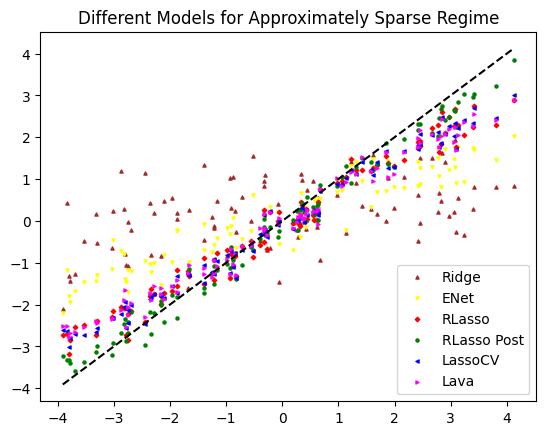

In [ ]:
plt.figure()
plt.title("Different Models for Approximately Sparse Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, ridge.predict(Xtest), marker='^', c='brown', s=5, label='Ridge')
plt.scatter(gXtest, enet.predict(Xtest), marker='v', c='yellow', s=5, label='ENet')
plt.scatter(gXtest, rlasso.predict(Xtest), marker='D', c='red', s=5, label='RLasso')
plt.scatter(gXtest, rlasso_post.predict(Xtest), marker='o', c='green', s=5, label='RLasso Post')
plt.scatter(gXtest, lcv.predict(Xtest), marker='<', c='blue', s=5, label='LassoCV')
plt.scatter(gXtest, lava.predict(Xtest), marker='>', c='magenta', s=5, label='Lava')
plt.legend(loc='lower right')

plt.show()

Insights:
1. Alignment with the diagonal line:

- Lava, R-Lasso Post, and LassoCV predictions cluster closely around the line → better predictive accuracy.
- Ridge predictions show more dispersion → underperforms in sparse settings (due to lack of variable selection).
Model Differences in Sparsity Handling:

2. Ridge struggles since it shrinks all coefficients, ignoring sparsity.
- Lasso-based models (LassoCV, R-Lasso, R-Lasso Post) perform better, highlighting their strength in sparse regimes.
- Lava captures both dense and sparse components, leading to robust performance.

3. Spread of Predictions:

- ENet shows moderate variance—combines L1 and L2 penalties but may not be optimal for pure sparsity.
- R-Lasso Post improves over R-Lasso by reducing shrinkage bias.

## Data Generating Process: Dense Coefficients

In [ ]:
n = 100 # sample size
p = 400 # no of predictors
X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, betas = gen_data(n, p, regime="dense")

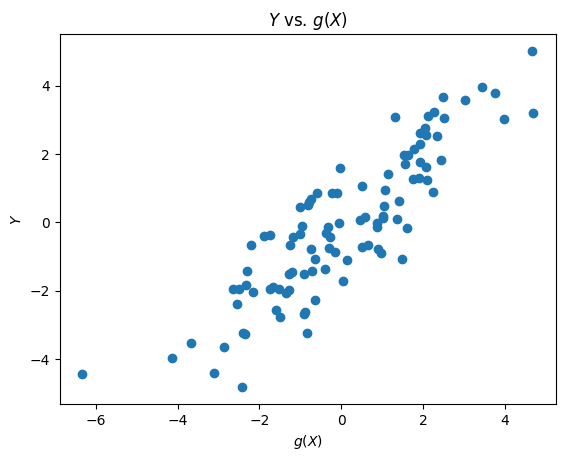

In [ ]:
plt.figure()
plt.title(r"$Y$ vs. $g(X)$")
plt.scatter(gX, y)
plt.xlabel(r"$g(X)$")
plt.ylabel(r"$Y$")
plt.show()

In [ ]:
print(f"theoretical R^2:, {1 - np.var(ypop - gXpop) / np.var(ypop)}")
print(f"theoretical R^2:, {np.var(gXpop) / np.var(ypop)}")

theoretical R^2:, 0.8141603102079493
theoretical R^2:, 0.815961116632237


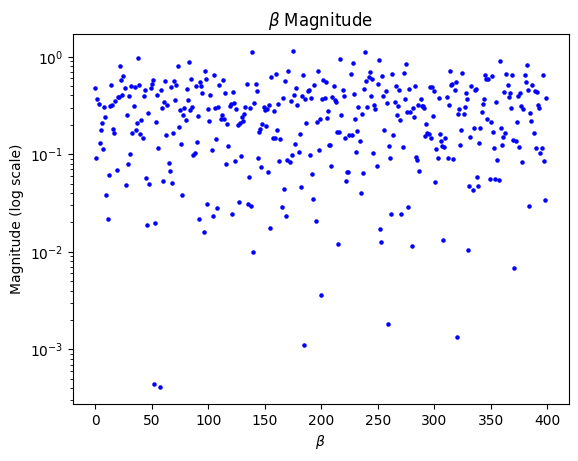

In [ ]:
plt.figure()
plt.scatter(range(len(betas)), abs(betas), s=5, color='b')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnitude (log scale)')
plt.title(r'$\beta$ Magnitude')
plt.yscale('log')
plt.show()

In [ ]:
# Regressions
lcv = LassoCV().fit(X, y)
ridge = RidgeCV(alphas=(1, 10, 25, 50, 100)).fit(X, y)
enet = ElasticNetCV(l1_ratio=0.5).fit(X, y)
rlasso = RLasso(post=False).fit(X, y)
rlasso_post = RLasso(post=True).fit(X, y)
lava = GridSearchCV(Lava(), {'alpha1': np.logspace(-4, 4, 20), 'alpha2': np.logspace(-4, 4, 20)},
                    scoring='r2', n_jobs=-1).fit(X, y)

In [ ]:
r2_lcv = r2_score(ypop, lcv.predict(Xpop))
r2_ridge = r2_score(ypop, ridge.predict(Xpop))
r2_enet = r2_score(ypop, enet.predict(Xpop))
r2_rlasso = r2_score(ypop, rlasso.predict(Xpop))
r2_rlasso_post = r2_score(ypop, rlasso_post.predict(Xpop))
r2_lava = r2_score(ypop, lava.predict(Xpop))

In [ ]:
df = pd.DataFrame({'LassoCV': [r2_lcv],
                   'RidgeCV': [r2_ridge],
                   'ElasticNetCV': [r2_enet],
                   'RLasso': [r2_rlasso],
                   'RLassoOLS': [r2_rlasso_post],
                   'Lava': [r2_lava]}).T
df.columns = ['Population R-squared']
df

,Population R-squared
LassoCV,0.009199
RidgeCV,0.111656
ElasticNetCV,0.039698
RLasso,0.005752
RLassoOLS,-0.061431
Lava,0.107363


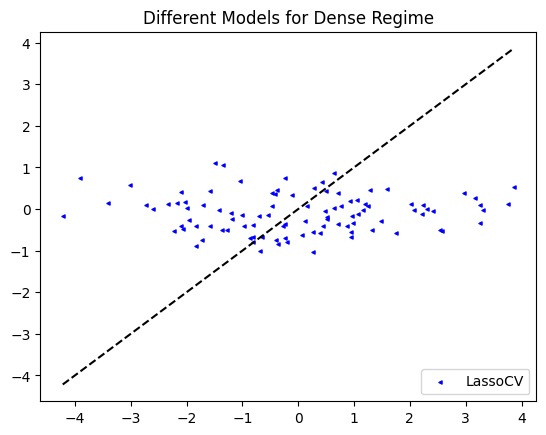

In [ ]:
plt.figure()
plt.title("Different Models for Dense Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, lcv.predict(Xtest), marker='<', c='blue', s=5, label='LassoCV')
plt.legend(loc='lower right')

plt.show()

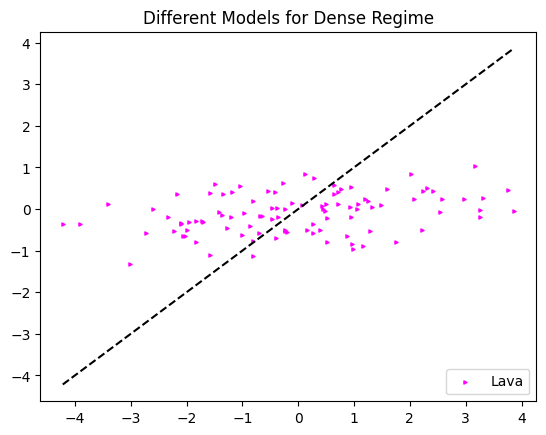

In [ ]:
plt.figure()
plt.title("Different Models for Dense Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, lava.predict(Xtest), marker='>', c='magenta', s=5, label='Lava')
plt.legend(loc='lower right')

plt.show()

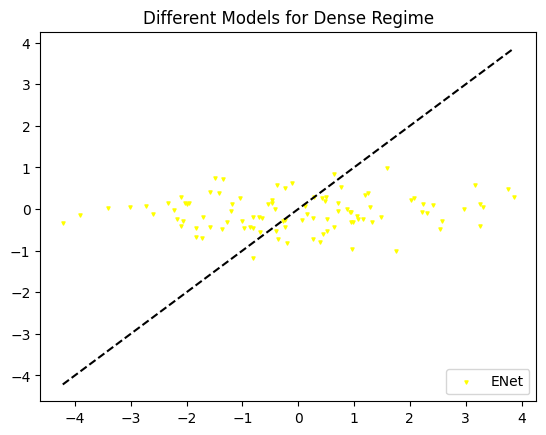

In [ ]:
plt.figure()
plt.title("Different Models for Dense Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, enet.predict(Xtest), marker='v', c='yellow', s=5, label='ENet')
plt.legend(loc='lower right')

plt.show()

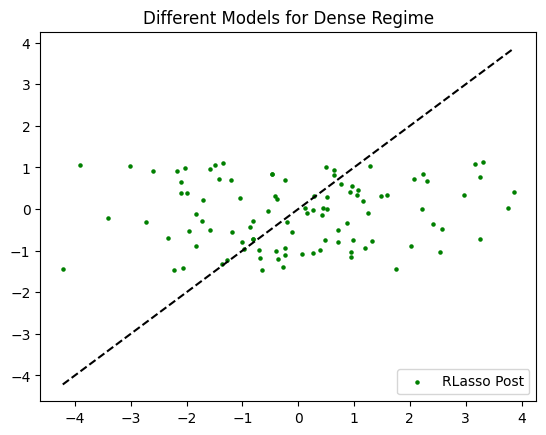

In [ ]:
plt.figure()
plt.title("Different Models for Dense Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, rlasso_post.predict(Xtest), marker='o', c='green', s=5, label='RLasso Post')
plt.legend(loc='lower right')

plt.show()

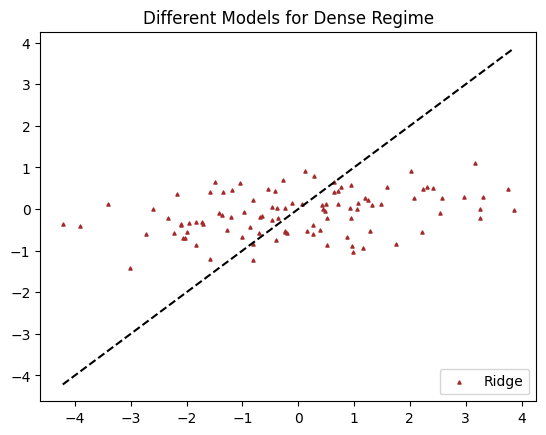

In [ ]:
plt.figure()
plt.title("Different Models for Dense Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, ridge.predict(Xtest), marker='^', c='brown', s=5, label='Ridge')
plt.legend(loc='lower right')

plt.show()

Key Observations:
1. Alignment with the Diagonal (Ideal Predictions):

- Ridge (brown triangles) predictions cluster closer to the diagonal than in the sparse regime → better suited for dense signals.
- Lasso-based models (LassoCV, R-Lasso, R-Lasso Post) show more scatter away from the diagonal, indicating weaker performance in this regime.

- R-Lasso and R-Lasso Post:

  - Both methods, designed for sparse recovery, underperform in this dense setting.
  - R-Lasso Post (green dots) shows many predictions flatlining near zero → a sign of excessive shrinkage.

-  Elastic Net (ENet) and Lava:

  - ENet (yellow inverted triangles) balances L1 and L2 penalties but still underperforms compared to Ridge.
  - Lava (magenta crosses) incorporates both L1 and L2 penalties through iterative adjustments and performs moderately well, though not as tightly clustered as Ridge predictions.
  
Prediction Variability:

Across models, predictions for larger true values (> 2 or < -2) show higher dispersion, indicating difficulty in capturing extreme values.


## Data Generating Process: Approximately Sparse + Small Dense Part

In [ ]:
n = 100
p = 400
X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, betas = gen_data(n, p, regime="sparsedense")

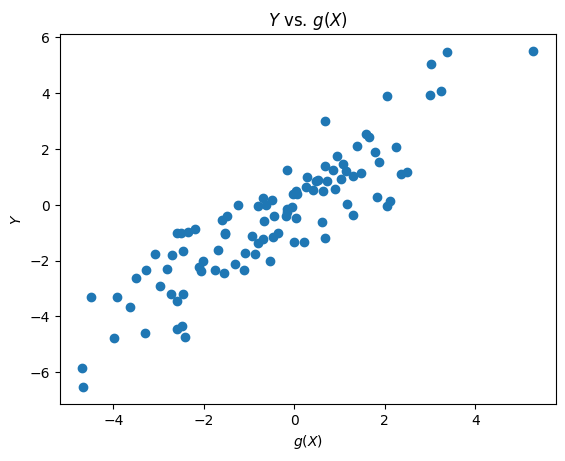

In [ ]:
plt.figure()
plt.title(r"$Y$ vs. $g(X)$")
plt.scatter(gX, y)
plt.xlabel(r"$g(X)$")
plt.ylabel(r"$Y$")
plt.show()

In [ ]:
print(f"theoretical R^2:, {1 - np.var(ypop - gXpop) / np.var(ypop)}")
print(f"theoretical R^2:, {np.var(gXpop) / np.var(ypop)}")

theoretical R^2:, 0.8039307863630024
theoretical R^2:, 0.8047665873619018


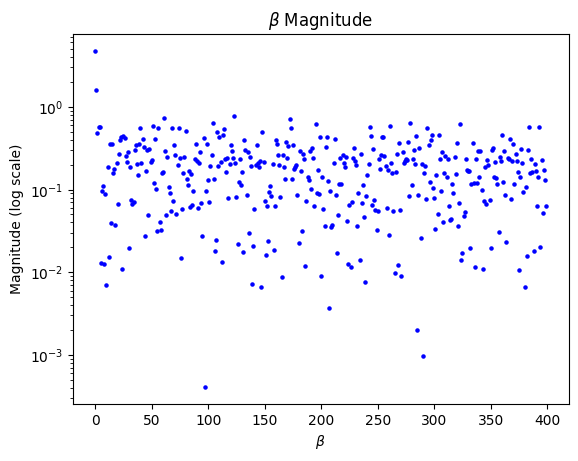

In [ ]:
plt.figure()
plt.scatter(range(len(betas)), abs(betas), s=5, color='b')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnitude (log scale)')
plt.title(r'$\beta$ Magnitude')
plt.yscale('log')
plt.show()

In [ ]:
# Regressions
lcv = LassoCV().fit(X, y)
ridge = RidgeCV().fit(X, y)
enet = ElasticNetCV(l1_ratio=0.5).fit(X, y)
rlasso = RLasso(post=False).fit(X, y)
rlasso_post = RLasso(post=True).fit(X, y)
lava = GridSearchCV(Lava(), {'alpha1': np.logspace(-4, 4, 20), 'alpha2': np.logspace(-4, 4, 20)},
                    scoring='r2', n_jobs=-1).fit(X, y)

In [ ]:
r2_lcv = r2_score(ypop, lcv.predict(Xpop))
r2_ridge = r2_score(ypop, ridge.predict(Xpop))
r2_enet = r2_score(ypop, enet.predict(Xpop))
r2_rlasso = r2_score(ypop, rlasso.predict(Xpop))
r2_rlasso_post = r2_score(ypop, rlasso_post.predict(Xpop))
r2_lava = r2_score(ypop, lava.predict(Xpop))

In [ ]:
df = pd.DataFrame({'LassoCV': [r2_lcv],
                   'RidgeCV': [r2_ridge],
                   'ElasticNetCV': [r2_enet],
                   'RLasso': [r2_rlasso],
                   'RLassoOLS': [r2_rlasso_post],
                   'Lava': [r2_lava]}).T
df.columns = ['Population R-squared']
df

,Population R-squared
LassoCV,0.170103
RidgeCV,0.088153
ElasticNetCV,0.218322
RLasso,0.301715
RLassoOLS,0.320847
Lava,0.257810


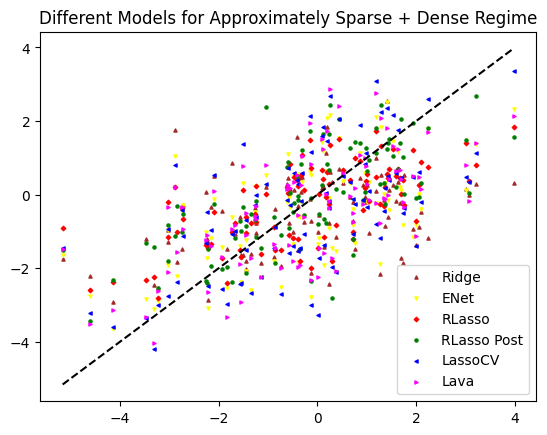

In [ ]:
plt.figure()
plt.title("Different Models for Approximately Sparse + Dense Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, ridge.predict(Xtest), marker='^', c='brown', s=5, label='Ridge')
plt.scatter(gXtest, enet.predict(Xtest), marker='v', c='yellow', s=5, label='ENet')
plt.scatter(gXtest, rlasso.predict(Xtest), marker='D', c='red', s=5, label='RLasso')
plt.scatter(gXtest, rlasso_post.predict(Xtest), marker='o', c='green', s=5, label='RLasso Post')
plt.scatter(gXtest, lcv.predict(Xtest), marker='<', c='blue', s=5, label='LassoCV')
plt.scatter(gXtest, lava.predict(Xtest), marker='>', c='magenta', s=5, label='Lava')
plt.legend(loc='lower right')

plt.show()

Key Observations:
1. Overall Alignment with the Diagonal (Ideal Predictions):

- No single model perfectly hugs the diagonal across all values → consistent with the challenge of mixed sparsity and density.
- Predictions are more scattered than the sparse regime but generally less dispersed than the purely dense regime.

2. Model-Specific Insights:

- Ridge (brown triangles):
Handles dense components well but struggles to capture sparse large signals, leading to underfitting in those regions.
- Lasso-based models (LassoCV, RLasso, RLasso Post):
Better at identifying sparse signals but miss out on many small effects → leads to underprediction for moderate values.
RLasso Post (green dots) shows shrinkage issues, with many predictions clustered near zero.
- Elastic Net (ENet, yellow inverted triangles):
Offers a compromise by balancing L1 and L2 penalties → performs moderately across the range.
- Lava (magenta crosses):
Stands out as it’s designed for mixed sparsity scenarios.
Provides a good balance of capturing both large (sparse) and small (dense) effects, evident from its relatively tight clustering along the diagonal.

3. Extreme Values and Variability:

- Across all models, predictions for large positive/negative true values (> 3 or < -3) show increased dispersion.
- This indicates difficulty in capturing outliers or extreme signals in the mixed regime.
